##  Carregando as bibliotecas e configurações

In [1]:
import pandas as pd
import sys
import os
import seaborn as sns
import locale

sys.path.append(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '')))
from utils.utils import ler_csv

Notebook Color Schema: 


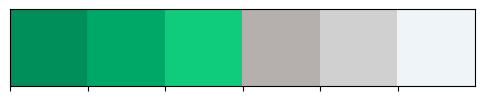

In [2]:
# Esquema de cores utilizados no report. As cores foram extraídas da página da empresa.
class clr:
    S = '\033[1m' + '\033[96m'
    E = '\033[0m'

my_colors = ['#008E5A', '#00A868', '#0FCC7D', '#B5B0AE', '#D0D0D0', '#EFF4F8']
sns.palplot(sns.color_palette(my_colors))
print(clr.S + "Notebook Color Schema: " + clr.E)

In [3]:
# Configurar locale para usar ponto como separador de milhar nos gráficos
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

'pt_BR.UTF-8'

Na parte analítica do report, serão plotados  gráficos para abordagem visual. Para evitar repetição no código, criei uma classe para plotar gráficos porque isso organiza o código em um único lugar, deixando a estrutura mais limpa e clara para leitura, facilita a reutilização e manutenção do código.

In [4]:
from utils.plot_config import configure_plot_style, PlotUtils
# Configurações globais de estilo para exibição no notebook
configure_plot_style()
%matplotlib inline

# Instanciando a classe
plotutils = PlotUtils()

## Tratamento e Engenharia de Dados

### Carregando os datasets

In [5]:
df_clientes = ler_csv(filepath='../datasets/clientes.csv')
df_estabelecimentos = ler_csv(filepath='../datasets/estabelecimentos.csv')
df_relacao_transacao_cliente = ler_csv(filepath='../datasets/relacao_transacao_cliente.csv')
df_transacoes = ler_csv(filepath='../datasets/transacoes.csv')

Arquivo '../datasets/clientes.csv' lido com sucesso!
Arquivo '../datasets/estabelecimentos.csv' lido com sucesso!
Arquivo '../datasets/relacao_transacao_cliente.csv' lido com sucesso!
Arquivo '../datasets/transacoes.csv' lido com sucesso!


### Desnormalização: merge da tabela-fato com as tabelas-dimensões

Este modelo segue a estrutura star schema, típica de data warehouses, com:
- Tabelas de dimensão (clientes, estabelecimentos, relação_transação_cliente) armazenando atributos descritivos.
- Tabela fato (transações) centralizando os eventos mensuráveis (valores, status).

Será realizado um MERGE/JOIN entre as tabelas de dimensão e a tabela fato para criar uma tabela consolidada.

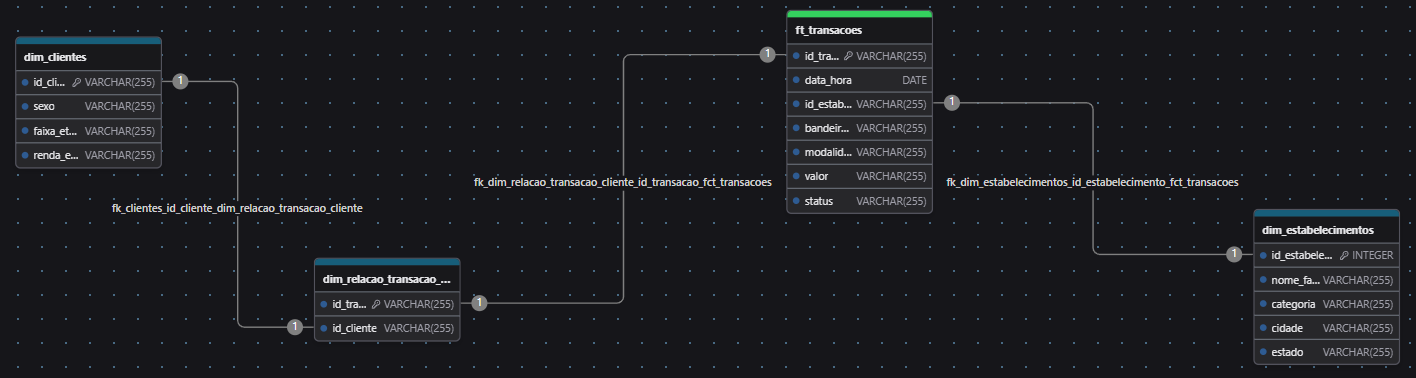

In [6]:
# 1. Merge da relação transação-cliente com os clientes
df_clientes_transacoes = pd.merge(
    df_relacao_transacao_cliente,
    df_clientes,
    on='id_cliente',
    how='left'
)

# 2. Merge do resultado anterior com as transações
df_transacoes_completo = pd.merge(
    df_transacoes,
    df_clientes_transacoes,
    on='id_transacao',
    how='left'
)

# 3. Merge com estabelecimentos
df = pd.merge(
    df_transacoes_completo,
    df_estabelecimentos,
    on='id_estabelecimento',
    how='left'
)
df

,id_transacao,data_hora,id_estabelecimento,bandeira_cartao,modalidade,valor,status,id_cliente,sexo,faixa_etaria,renda_estimada,nome_fantasia,categoria,cidade,estado
0,trx_0,2024-06-24 23:00:00,estab_5,Mastercard,crédito,13.48,aprovada,cli_344,F,18-25,2k-5k,Carvalho S.A.,mercado,Alves,AP
1,trx_1,2024-07-20 07:00:00,estab_24,Hipercard,débito,541.70,recusada,cli_309,M,36-45,5k-10k,da Cruz Mendes - ME,restaurante,Porto de da Cunha,TO
2,trx_2,2024-04-25 08:00:00,estab_30,Elo,débito,772.15,aprovada,cli_11,F,46-60,5k-10k,Araújo - EI,farmácia,Dias de Gonçalves,MG
3,trx_3,2024-05-12 18:00:00,estab_8,Mastercard,débito,751.27,aprovada,cli_64,M,18-25,10k+,Dias - ME,farmácia,da Rocha do Amparo,PB
4,trx_4,2024-04-17 05:00:00,estab_19,Elo,débito,906.99,estornada,cli_181,F,26-35,<2k,Novais Leão S.A.,vestuário,Porto da Serra,AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,trx_9995,2024-10-08 17:00:00,estab_9,Visa,débito,1311.83,aprovada,cli_412,M,60+,5k-10k,Machado,eletrodomésticos,da Costa,PA
9996,trx_9996,2024-09-11 14:00:00,estab_34,Hipercard,débito,1047.56,aprovada,cli_79,M,46-60,2k-5k,Cavalcante,farmácia,Azevedo,MS
9997,trx_9997,2024-10-16 19:00:00,estab_35,Visa,crédito,769.11,recusada,cli_418,M,60+,<2k,Rodrigues,eletrodomésticos,Cavalcanti de Cunha,TO
9998,trx_9998,2024-01-05 10:00:00,estab_32,Mastercard,débito,471.24,aprovada,cli_274,M,26-35,<2k,Monteiro Novais - EI,vestuário,Rios,BA


Antes da análise, é necessário investigar se há valores inesperados nas colunas categóricas

In [7]:
valores_unicos = {
    'bandeira_cartao': df['bandeira_cartao'].unique(),
    'modalidade': df['modalidade'].unique(),
    'status': df['status'].unique(),
    'sexo': df['sexo'].unique(),
    'faixa_etaria': df['faixa_etaria'].unique(),
    'renda_estimada': df['renda_estimada'].unique(),
    'categoria': df['categoria'].unique()
}

for coluna, valores in valores_unicos.items():
    print(f"\n{coluna.upper()}:")
    print(valores)


BANDEIRA_CARTAO:
['Mastercard' 'Hipercard' 'Elo' 'Visa']

MODALIDADE:
['crédito' 'débito']

STATUS:
['aprovada' 'recusada' 'estornada']

SEXO:
['F' 'M']

FAIXA_ETARIA:
['18-25' '36-45' '46-60' '26-35' '60+']

RENDA_ESTIMADA:
['2k-5k' '5k-10k' '10k+' '<2k']

CATEGORIA:
['mercado' 'restaurante' 'farmácia' 'vestuário' 'eletrodomésticos']


Percebe-se que a base já veio limpa e praticamente tratada. Nas categorias e seus valores únicos, não percebeu-se nenhum valor nas categorias que exigissem tratamento.

Também não foi necessário fazer nenhuma correção de encoding nos dados antes da análise.

### Solicitação: Criação de novas colunas

In [8]:
# Coluna mês da transação
df['mes_transacao'] = pd.to_datetime(df['data_hora']).dt.month

# Valor acumulado por cliente
df['valor_acumulado_cliente'] = df.groupby('id_cliente')['valor'].cumsum()

# valor acumulado por estabelecimento
df['valor_acumulado_estabelecimento'] = df.groupby('id_estabelecimento')['valor'].cumsum()

### Engenharia de Dados: Transformando as colunas em tipos adequados

In [9]:
## Fazendo algumas transformações necessárias
# Converter as colunas para string:
colunas_string = ['id_transacao', 'id_estabelecimento', 'id_cliente', 'nome_fantasia', 'cidade']
for coluna in colunas_string:
    df[coluna] = df[coluna].astype('str')


# Converter as colunas para datetime:
colunas_datetime = ['data_hora']
for coluna in colunas_datetime:
    df[coluna] = pd.to_datetime(df[coluna], format='%Y-%m-%d %H:%M:%S')


# Definir a colunas como categoricas
colunas_categoricas = ['bandeira_cartao', 'modalidade', 'status', 'categoria', 'estado']
for coluna in colunas_categoricas:
    df[coluna] = df[coluna].astype('category')


# Transformações de valores dentro da coluna sexo
map_sexo = {"M": "Masculino", "F": "Feminino"}
df['sexo'] = df['sexo'].map(map_sexo)
df['sexo'] = df['sexo'].astype('category')


# Definir a coluna faixa_etaria como categórica e com ordem
ordem_idades = ['18-25', '36-45', '46-60', '26-35', '60+']
df['faixa_etaria'] = pd.Categorical(df['faixa_etaria'], categories=ordem_idades, ordered=True)


# Definir a coluna renda_estimada como categórica e com ordem
ordem_renda = ['<2k', '2k-5k', '5k-10k', '10k+']
df['renda_estimada'] = pd.Categorical(df['renda_estimada'], categories=ordem_renda, ordered=True)

# Checando
df.dtypes

id_transacao                               object
data_hora                          datetime64[ns]
id_estabelecimento                         object
bandeira_cartao                          category
modalidade                               category
valor                                     float64
status                                   category
id_cliente                                 object
sexo                                     category
faixa_etaria                             category
renda_estimada                           category
nome_fantasia                              object
categoria                                category
cidade                                     object
estado                                   category
mes_transacao                               int32
valor_acumulado_cliente                   float64
valor_acumulado_estabelecimento           float64
dtype: object

### Análise Exploratória

Para essa sessão foram plotados alguns gráficos para análise exploratória dos dados (EDA). Ao final dessa sessão, encontra-se a interpretação do comportamento de cada categoria.

#### Bandeira Cartão

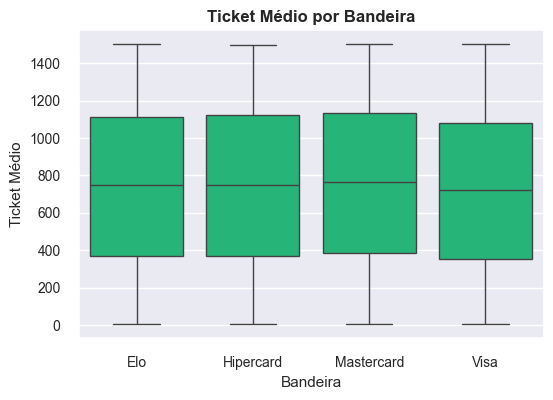

,bandeira_cartao,quantidade_transacoes,ticket_medio
0,Elo,2496,748
1,Hipercard,2566,748
2,Mastercard,2449,758
3,Visa,2489,726


In [10]:
ticket_medio_por_bandeira = (
    df
    .groupby('bandeira_cartao', observed=False)['valor']
    .agg(['count', 'mean'])
    .reset_index()
    .sort_values('bandeira_cartao')
    .rename(columns={
        'count': 'quantidade_transacoes',
        'mean': 'ticket_medio'
    })
    .assign(ticket_medio=lambda x: x['ticket_medio'].astype(int))
)
plotutils.box_plot(
    data=df,
    x='bandeira_cartao',
    y='valor',
    title='Ticket Médio por Bandeira',
    xlabel='Bandeira',
    ylabel='Ticket Médio',
)

ticket_medio_por_bandeira

#### Modalidade de Pagamento (débito ou crédito)

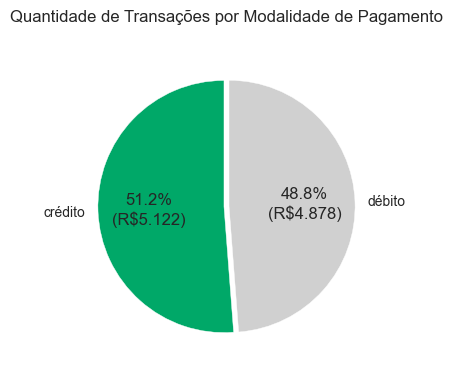

,modalidade,quantidade_transacoes,ticket_medio
0,crédito,5122,748
1,débito,4878,741


In [11]:
ticket_medio_por_modalidade = (
    df
    .groupby('modalidade', observed=False)['valor']
    .agg(['count', 'mean'])
    .reset_index()
    .sort_values('modalidade')
    .rename(columns={
        'count': 'quantidade_transacoes',
        'mean': 'ticket_medio'
    })
    .assign(ticket_medio=lambda x: x['ticket_medio'].astype(int))
)
plotutils.pie_chart(
    data=ticket_medio_por_modalidade.set_index('modalidade')['quantidade_transacoes'],
    colors=['#00A868', '#D0D0D0'],
    title='Quantidade de Transações por Modalidade de Pagamento'
)
ticket_medio_por_modalidade

#### Status do pedido

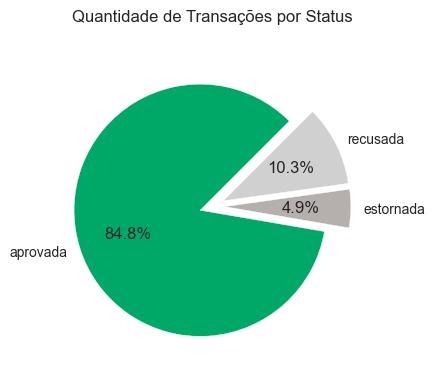

,status,quantidade_transacoes,ticket_medio
0,aprovada,8480,742
1,estornada,491,767
2,recusada,1029,758


In [12]:
ticket_medio_por_status = (
    df
    .groupby('status', observed=False)['valor']
    .agg(['count', 'mean'])
    .reset_index()
    .sort_values('status')
    .rename(columns={
        'count': 'quantidade_transacoes',
        'mean': 'ticket_medio'
    })
    .assign(ticket_medio=lambda x: x['ticket_medio'].astype(int))
)
plotutils.pie_chart(
    data=ticket_medio_por_status.set_index('status')['quantidade_transacoes'],
    title='Quantidade de Transações por Status',
    autopct_format='percent',
    startangle=45, 
    colors=['#00A868', '#B5B0AE', '#D0D0D0'],
    explode=[0.1]*len(ticket_medio_por_status)
)

ticket_medio_por_status

#### Faixa Etária

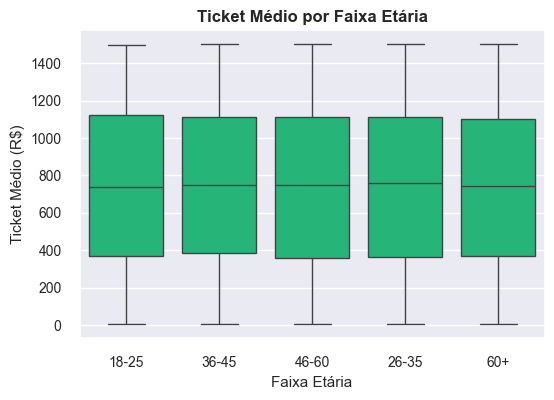

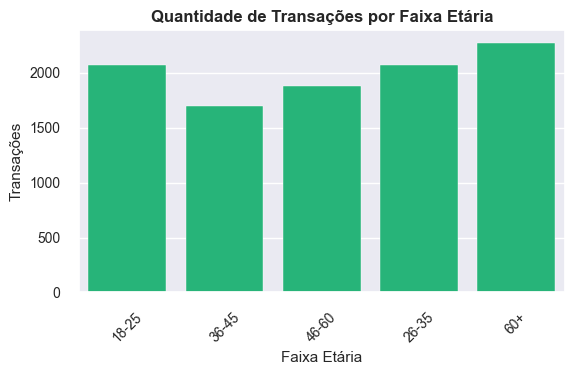

,faixa_etaria,quantidade_transacoes,ticket_medio
0,18-25,2071,744
1,36-45,1695,752
2,46-60,1886,737
3,26-35,2074,748
4,60+,2274,744


In [13]:
# Análise do ticket médio por faixa etária
ticket_medio_por_faixa_etaria = (
    df
    .groupby('faixa_etaria', observed=False)['valor']
    .agg(['count', 'mean'])
    .reset_index()
    .sort_values('faixa_etaria')  # Ordena por ordem lógica de idade (ex: "18-24", "25-34", etc.)
    .rename(columns={
        'count': 'quantidade_transacoes',
        'mean': 'ticket_medio'
    })
    .assign(ticket_medio=lambda x: x['ticket_medio'].astype(int))
)
plotutils.box_plot(
    data=df,
    x='faixa_etaria',
    y='valor',
    title='Ticket Médio por Faixa Etária',
    xlabel='Faixa Etária',
    ylabel='Ticket Médio (R$)',
)
plotutils.bar_plot(
    data=ticket_medio_por_faixa_etaria,
    x='faixa_etaria',
    y='quantidade_transacoes',
    title='Quantidade de Transações por Faixa Etária',
    xlabel='Faixa Etária',
    ylabel='Transações'
)
ticket_medio_por_faixa_etaria

#### Renda Estimada

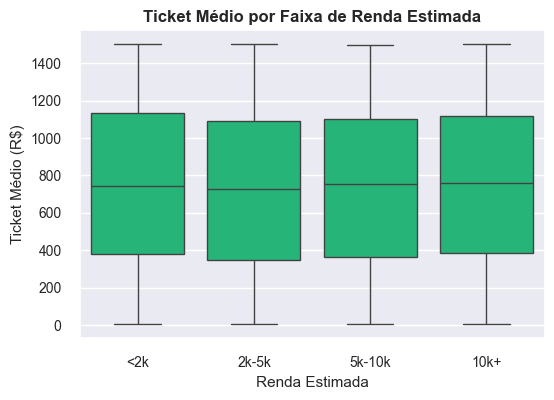

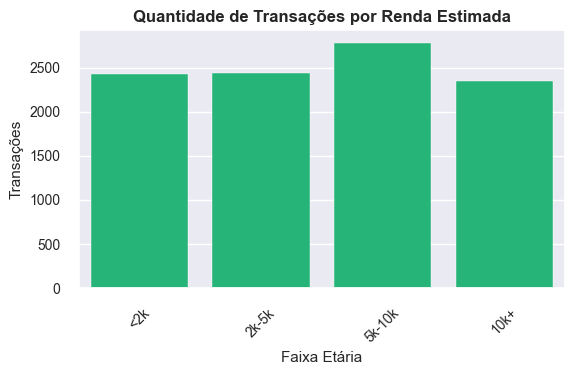

,faixa_etaria,quantidade_transacoes,ticket_medio
0,18-25,2071,744
1,36-45,1695,752
2,46-60,1886,737
3,26-35,2074,748
4,60+,2274,744


In [14]:
ticket_medio_por_renda = (
    df
    .groupby('renda_estimada', observed=False)['valor']
    .agg(['count', 'mean'])  # Adicionando estatísticas robustas
    .reset_index()
    .sort_values('renda_estimada')  # Ordena por ordem crescente de renda
    .rename(columns={
        'count': 'quantidade_transacoes',
        'mean': 'ticket_medio'
    }
    ).assign(ticket_medio=lambda x: x['ticket_medio'].astype(int))
)
plotutils.box_plot(
    data=df,
    x='renda_estimada',
    y='valor',
    title='Ticket Médio por Faixa de Renda Estimada',
    xlabel='Renda Estimada',
    ylabel='Ticket Médio (R$)',
)
plotutils.bar_plot(
    data=ticket_medio_por_renda,
    x='renda_estimada',
    y='quantidade_transacoes',
    title='Quantidade de Transações por Renda Estimada',
    xlabel='Faixa Etária',
    ylabel='Transações'
)
ticket_medio_por_faixa_etaria

#### Sexo / Gênero

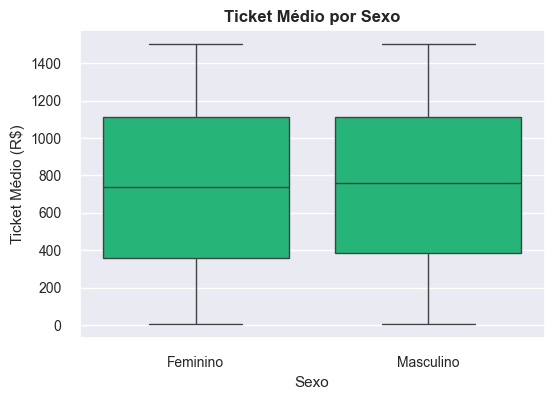

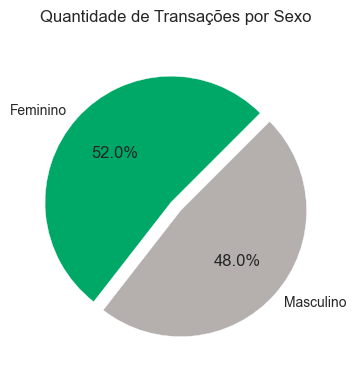

,sexo,quantidade_transacoes,ticket_medio
0,Feminino,5198,738
1,Masculino,4802,753


In [15]:
ticket_medio_por_sexo = (
    df
    .groupby('sexo', observed=False)['valor']
    .agg(['count', 'mean'])
    .reset_index()
    .sort_values('sexo')
    .rename(columns={
        'count': 'quantidade_transacoes',
        'mean': 'ticket_medio'
    })
    .assign(ticket_medio=lambda x: x['ticket_medio'].astype(int))
)
plotutils.box_plot(
    data=df,
    x='sexo',
    y='valor',
    title='Ticket Médio por Sexo',
    xlabel='Sexo',
    ylabel='Ticket Médio (R$)',
)
plotutils.pie_chart(
    data=ticket_medio_por_sexo.set_index('sexo')['quantidade_transacoes'],
    title='Quantidade de Transações por Sexo',
    autopct_format='percent',
    startangle=45, 
    colors=['#00A868', '#B5B0AE'],
    explode=[0.05]*len(ticket_medio_por_sexo)
)

ticket_medio_por_sexo

#### Categoria

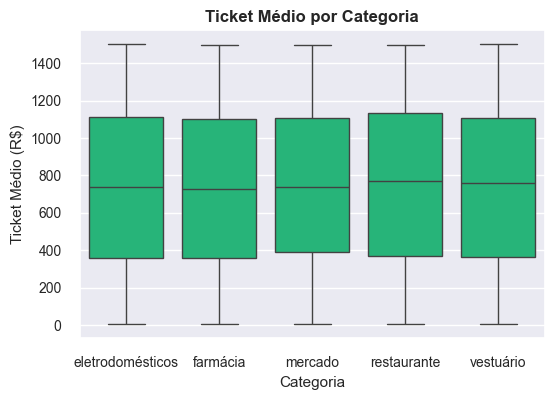

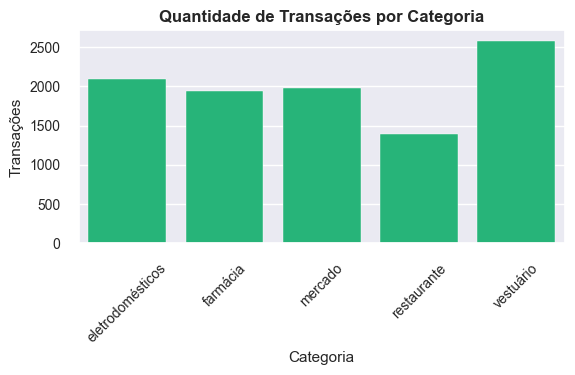

,categoria,quantidade_transacoes,ticket_medio
0,eletrodomésticos,2096,741
1,farmácia,1939,733
2,mercado,1985,746
3,restaurante,1395,757
4,vestuário,2585,750


In [16]:
ticket_medio_por_categoria = (
    df
    .groupby('categoria', observed=False)['valor']
    .agg(['count', 'mean'])
    .reset_index()
    .sort_values('categoria')
    .rename(columns={
        'count': 'quantidade_transacoes',
        'mean': 'ticket_medio'
    })
    .assign(ticket_medio=lambda x: x['ticket_medio'].astype(int))
)

# Boxplot (mesmo formato)
plotutils.box_plot(
    data=df,
    x='categoria',
    y='valor',
    title='Ticket Médio por Categoria',
    xlabel='Categoria',
    ylabel='Ticket Médio (R$)',
)

# Gráfico de barras (idêntico ao exemplo)
plotutils.bar_plot(
    data=ticket_medio_por_categoria,
    x='categoria',
    y='quantidade_transacoes',
    title='Quantidade de Transações por Categoria',
    xlabel='Categoria',
    ylabel='Transações'
)

ticket_medio_por_categoria

#### Estado (UF)

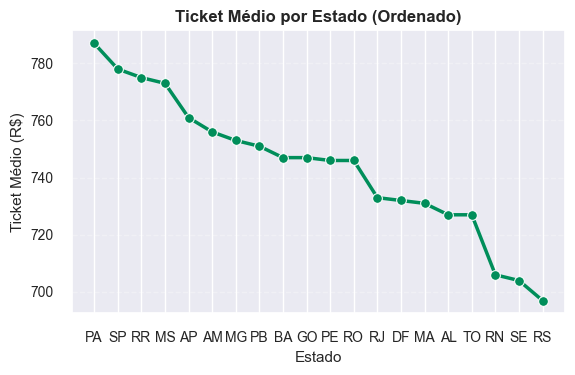

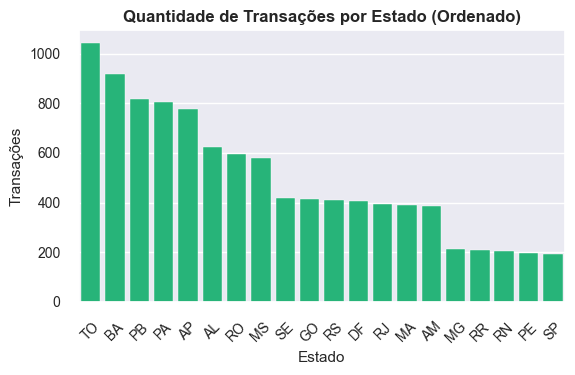

,estado,quantidade_transacoes,ticket_medio
9,PA,805,787
18,SP,191,778
15,RR,210,775
8,MS,578,773
2,AP,779,761
1,AM,387,756
7,MG,214,753
10,PB,818,751
3,BA,919,747
5,GO,416,747


In [17]:
ticket_medio_por_estado = (
    df
    .groupby('estado', observed=False)['valor']
    .agg(['count', 'mean'])
    .reset_index()
    .sort_values('mean', ascending=False)
    .rename(columns={
        'count': 'quantidade_transacoes',
        'mean': 'ticket_medio'
    })
    .assign(ticket_medio=lambda x: x['ticket_medio'].astype(int))
)
# Ordenando o dataframe pelo ticket médio - para o grafico de linha
df_ordenado = ticket_medio_por_estado.sort_values('ticket_medio', ascending=False)
ordem_estados = df_ordenado['estado'].tolist()
df_ordenado['estado'] = pd.Categorical(
    df_ordenado['estado'], 
    categories=ordem_estados, 
    ordered=True
)
plotutils.line_plot(
    data=df_ordenado,
    x='estado',
    y='ticket_medio',
    title='Ticket Médio por Estado (Ordenado)',
    xlabel='Estado',
    ylabel='Ticket Médio (R$)',
    color_index=0,
    marker='o'
)
# Ordenando o dataframe pela quantidade de transações - para o grafico de barras
df_ordenado = ticket_medio_por_estado.sort_values('quantidade_transacoes', ascending=False)
ordem_estados = df_ordenado['estado'].tolist()
df_ordenado['estado'] = pd.Categorical(
    df_ordenado['estado'], 
    categories=ordem_estados, 
    ordered=True
)
plotutils.bar_plot(
    data=df_ordenado,
    x='estado',
    y='quantidade_transacoes',
    title='Quantidade de Transações por Estado (Ordenado)',
    xlabel='Estado',
    ylabel='Transações'
)
ticket_medio_por_estado

### Conclusões